In [1]:
using CSV, DataFrames
using PyPlot
using Distributions
using ProgressMeter

# Ingest data

In [2]:
data = CSV.read("/home/liam/Work/caption-contest-data/contests/summaries/558_summary_LilUCB.csv")
# # make sure the data is sorted by caption rank
sort!(data, :rank);

In [3]:
"Returns a list of categorical distributions, one per arm."
function contest_arm_distributions(contest_data)
    n_captions = size(data, 1)
    probs = hcat([data[:,6+j]./data[:,6] for j in 1:3]...)
    
    distributions = [Categorical(probs[i,:]) for i in 1:n_captions]
end

distributions = contest_arm_distributions(data);

# Models
## KL-UCB

In [4]:
const Arm = Int
const Reward = Int

type KlucbState
    N :: Int
    δ :: Float64
    xsum :: Array{Int,1}
    x2sum :: Array{Int,1}
    T :: Array{Int,1}
    μ :: Array{Float64,1}
    UCB :: Array{Float64,1}

    function KlucbState(N::Int, δ::Float64)
        new(N, δ,
            zeros(N), zeros(N), zeros(N),
            [Inf for _=1:N], [Inf for _=1:N])
    end
end

function getQuery(state::KlucbState)::Arm
    findmax(state.UCB)[2]
end

function processAnswer!(state::KlucbState, arm::Arm, reward::Reward)
    state.xsum[arm] += reward
    state.x2sum[arm] += reward^2
    state.T[arm] += 1

    state.μ[arm] = state.xsum[arm] / state.T[arm]
    state.UCB[arm] = computeUCB((state.μ[arm]-1)/2,
        log(2*state.T[arm].^2/state.δ)/state.T[arm])
end

function computeUCB(μ_hat, threshold, accuracy=(1e-6))
    lower = μ_hat
    upper = 1
    ucb = (lower+upper)/2
    while (upper-lower) > accuracy
        lower, upper, ucb = leftright(μ_hat, lower, upper, threshold)
    end

    return ucb
end

function leftright(μ_hat, lower, upper, threshold)
    if μ_hat*(1-μ_hat) != 0
        shit = (upper+lower)/2
        kl = μ_hat*log(μ_hat/shit) + (1-μ_hat)*log((1-μ_hat)/(1-shit))
        if kl >= threshold
            return lower, shit, (shit+lower)/2
        else
            return shit, upper, (shit+upper)/2
        end
    end

    if μ_hat == 0
        shit = (upper+lower)/2
        kl = (1-μ_hat)*log((1-μ_hat)/(1-shit))
        if kl >= threshold
            return lower, shit, (shit+lower)/2
        else
            return shit, upper, (shit+upper)/2
        end
    end

    if μ_hat == 1
        return 1, 1, 1
    end
end

function precision_of(model; set=:)
    sqrt.(max.(1., model.x2sum[set] - model.T[set] .* model.μ[set].^2) ./ (model.T[set] - 1) ./ model.T[set])
end

precision_of (generic function with 1 method)

In [8]:
N = size(data,1)
# T = N*40
T = 524297
model = KlucbState(N, .5)
samples = []
@showprogress for t in 1:T
    arm = getQuery(model)
    reward = rand(distributions[arm])
    processAnswer!(model, arm, reward)
    push!(samples, precision_of(model, set=1:10))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


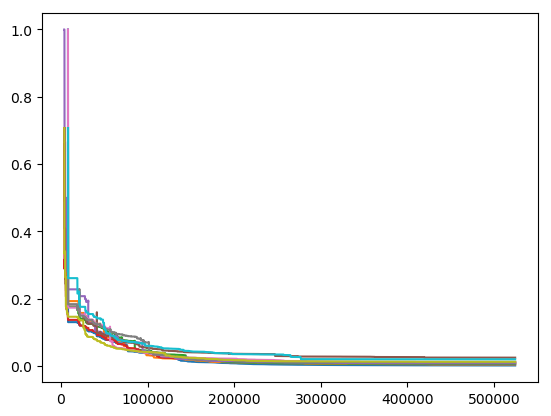

In [9]:
plot(samples); show()

In [37]:
model

KlucbState(3925, 0.5, [11243, 3488, 2684, 1531, 2538, 2716, 3201, 2177, 1863, 1786  …  12, 12, 12, 12, 12, 12, 12, 12, 12, 12], [24143, 7232, 5546, 3139, 5298, 5646, 6735, 4539, 3907, 3740  …  12, 12, 12, 12, 12, 12, 12, 12, 12, 12], [6313, 2018, 1566, 913, 1484, 1584, 1857, 1280, 1102, 1058  …  12, 12, 12, 12, 12, 12, 12, 12, 12, 12], [1.78093, 1.72844, 1.71392, 1.67689, 1.71024, 1.71465, 1.72375, 1.70078, 1.69056, 1.68809  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.428582, 0.427194, 0.427269, 0.427118, 0.427081, 0.427285, 0.427167, 0.427096, 0.42709, 0.427305  …  0.411204, 0.411204, 0.411204, 0.411204, 0.411204, 0.411204, 0.411204, 0.411204, 0.411204, 0.411204])

In [42]:
sum(data[:count])

524297.0

In [12]:
data[:precision]

3925-element Array{Union{Float64, Missings.Missing},1}:
 0.0247975
 0.0260765
 0.0283605
 0.0275904
 0.0287641
 0.0289608
 0.0299758
 0.0299378
 0.0312654
 0.0321183
 0.0321716
 0.0315459
 0.0307333
 ⋮        
 0.0124226
 0.0124226
 0.0124226
 0.0124226
 0.0124226
 0.0124226
 0.0124226
 0.0124226
 0.0124226
 0.0124226
 0.0124226
 0.0124226

In [10]:
precision_of(model)

3925-element Array{Float64,1}:
 0.00161452
 0.00465459
 0.00658696
 0.0103667 
 0.00807538
 0.0248954 
 0.0120997 
 0.0109338 
 0.0127089 
 0.019992  
 0.0123393 
 0.0156686 
 0.0136277 
 ⋮         
 0.0741249 
 0.0741249 
 0.0741249 
 0.0741249 
 0.0741249 
 0.0741249 
 0.0741249 
 0.0741249 
 0.0741249 
 0.0741249 
 0.0741249 
 0.0741249 